# Assignment Questions

**Q1.** Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three versions of the UCI dataset: a) Raw data from accelerometer, b) TSFEL featurised data, c) Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform?

**Q2.** Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform?

Firsly after collecting all the data, we preprocess it. We used the Physics Toolbox Suite app to collect the data. However there were some difficulties which we faced when preprocessing the data. The data that was collected was sampled at the highest frequency possible from our mobile. Hence the samples were also not evenly spaced. The sampling frequency kept changing. This made it difficult to use the data as it is. So we took a sliding window of 20 miliseconds and calculated the mean of the samples in that window. This way we were able to get evenly spaced samples at a frequency of 50 Hz.

## 1. Setup and Imports

In [222]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from tqdm import tqdm

### Load and Preprocess Train Data.

In [ ]:
import os
import numpy as np
import pandas as pd

# Now build path safely
base_dir = os.path.join("Datasets","processed_trimmed")

# Desired label mapping
label_map = {
    "WALKING": 1,
    "WALKING_UPSTAIRS": 2,
    "WALKING_DOWNSTAIRS": 3,
    "SITTING": 4,
    "STANDING": 5,
    "LAYING": 6
}

X_list, y_list = [], []

# Loop through activities in order of label_map
for activity, label in label_map.items():
    act_dir = os.path.join(base_dir, activity)
    files = [f for f in os.listdir(act_dir) if f.lower().endswith(".csv")]
    files.sort()  # ensure consistent order

    # Take first 3 files from each activity
    for fname in files[:]:
        fpath = os.path.join(act_dir, fname)
        df = pd.read_csv(fpath)

        # Keep numeric columns only
        df = df.select_dtypes(include=[np.number])

        # Store data and label
        X_list.append(df.values)  # (T, F)
        y_list.append(label)

# Convert to arrays
X = np.array(X_list, dtype=float)   # (18, T, F)
X_test_flat = X.reshape(X.shape[0], -1)  # (18, T*F)
y_test = np.array(y_list, dtype=int)

# Print checks
print("X shape       :", X.shape)
print("X_test_flat shape  :", X_test_flat.shape)
print("y_test shape  :", y_test.shape)



X shape       : (18, 500, 3)
X_test_flat shape  : (18, 1500)
y_test shape  : (18,)


### Load and Preprocess Test Data

In [225]:
from MakeDataset import X_train, y_train
# classes = {0:"WALKING", 1:"WALKING_UPSTAIRS", 2:"WALKING_DOWNSTAIRS", 3:"SITTING", 4:"STANDING", 5:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")


X_train shape: (126, 500, 3)
y_train shape: (126,)
X_train_flat shape: (126, 1500)


### Training Decision Tree on UCI HAR raw data, testing on custom raw data


In [226]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred1 = clf.predict(X_test_flat)

depth = clf.get_depth()
print("Depth of Decision Tree:", depth)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Depth of Decision Tree: 8
Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



### Classification Report, Confusion Matrix and Decision Tree

In [227]:
activities=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]


# 1. Classification Report (per-class + macro/micro avg)
print("Classification Report:\n")
print(classification_report(y_test, y_pred1, target_names=activities))

# 2. Overall Accuracy
accuracy = accuracy_score(y_test, y_pred1)
print(f"Overall Accuracy: {accuracy:.4f}")

# 3. Macro Precision & Recall
precision_macro = precision_score(y_test, y_pred1, average='macro')
recall_macro = recall_score(y_test, y_pred1, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00         3
  WALKING_UPSTAIRS       0.00      0.00      0.00         3
WALKING_DOWNSTAIRS       0.00      0.00      0.00         3
           SITTING       0.00      0.00      0.00         3
          STANDING       0.00      0.00      0.00         3
            LAYING       0.19      1.00      0.32         3

          accuracy                           0.17        18
         macro avg       0.03      0.17      0.05        18
      weighted avg       0.03      0.17      0.05        18

Overall Accuracy: 0.1667
Macro Precision: 0.0312
Macro Recall:    0.1667


c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

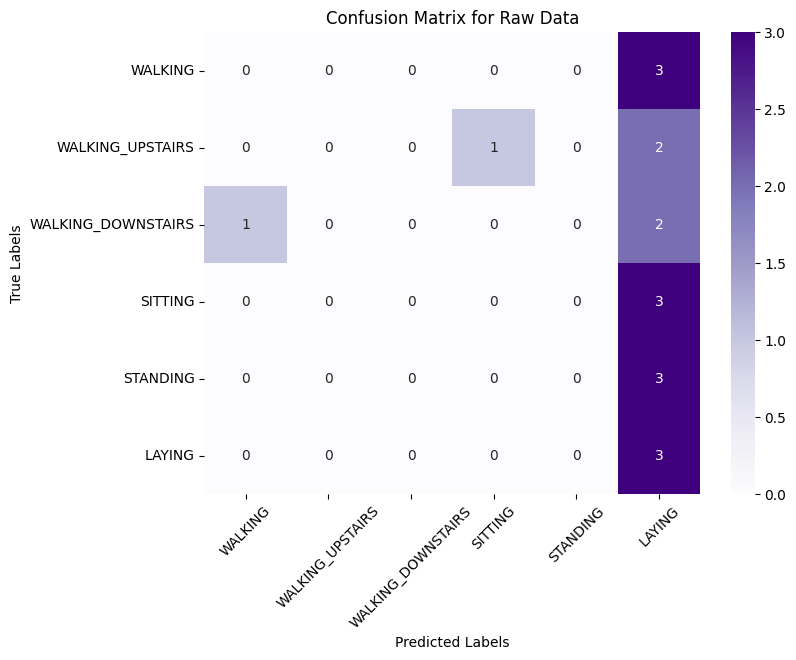

In [228]:
conf_matrix = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', 
            xticklabels=activities, 
            yticklabels=activities)

plt.xticks(rotation=45)  
plt.yticks()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Raw Data')

plt.show()


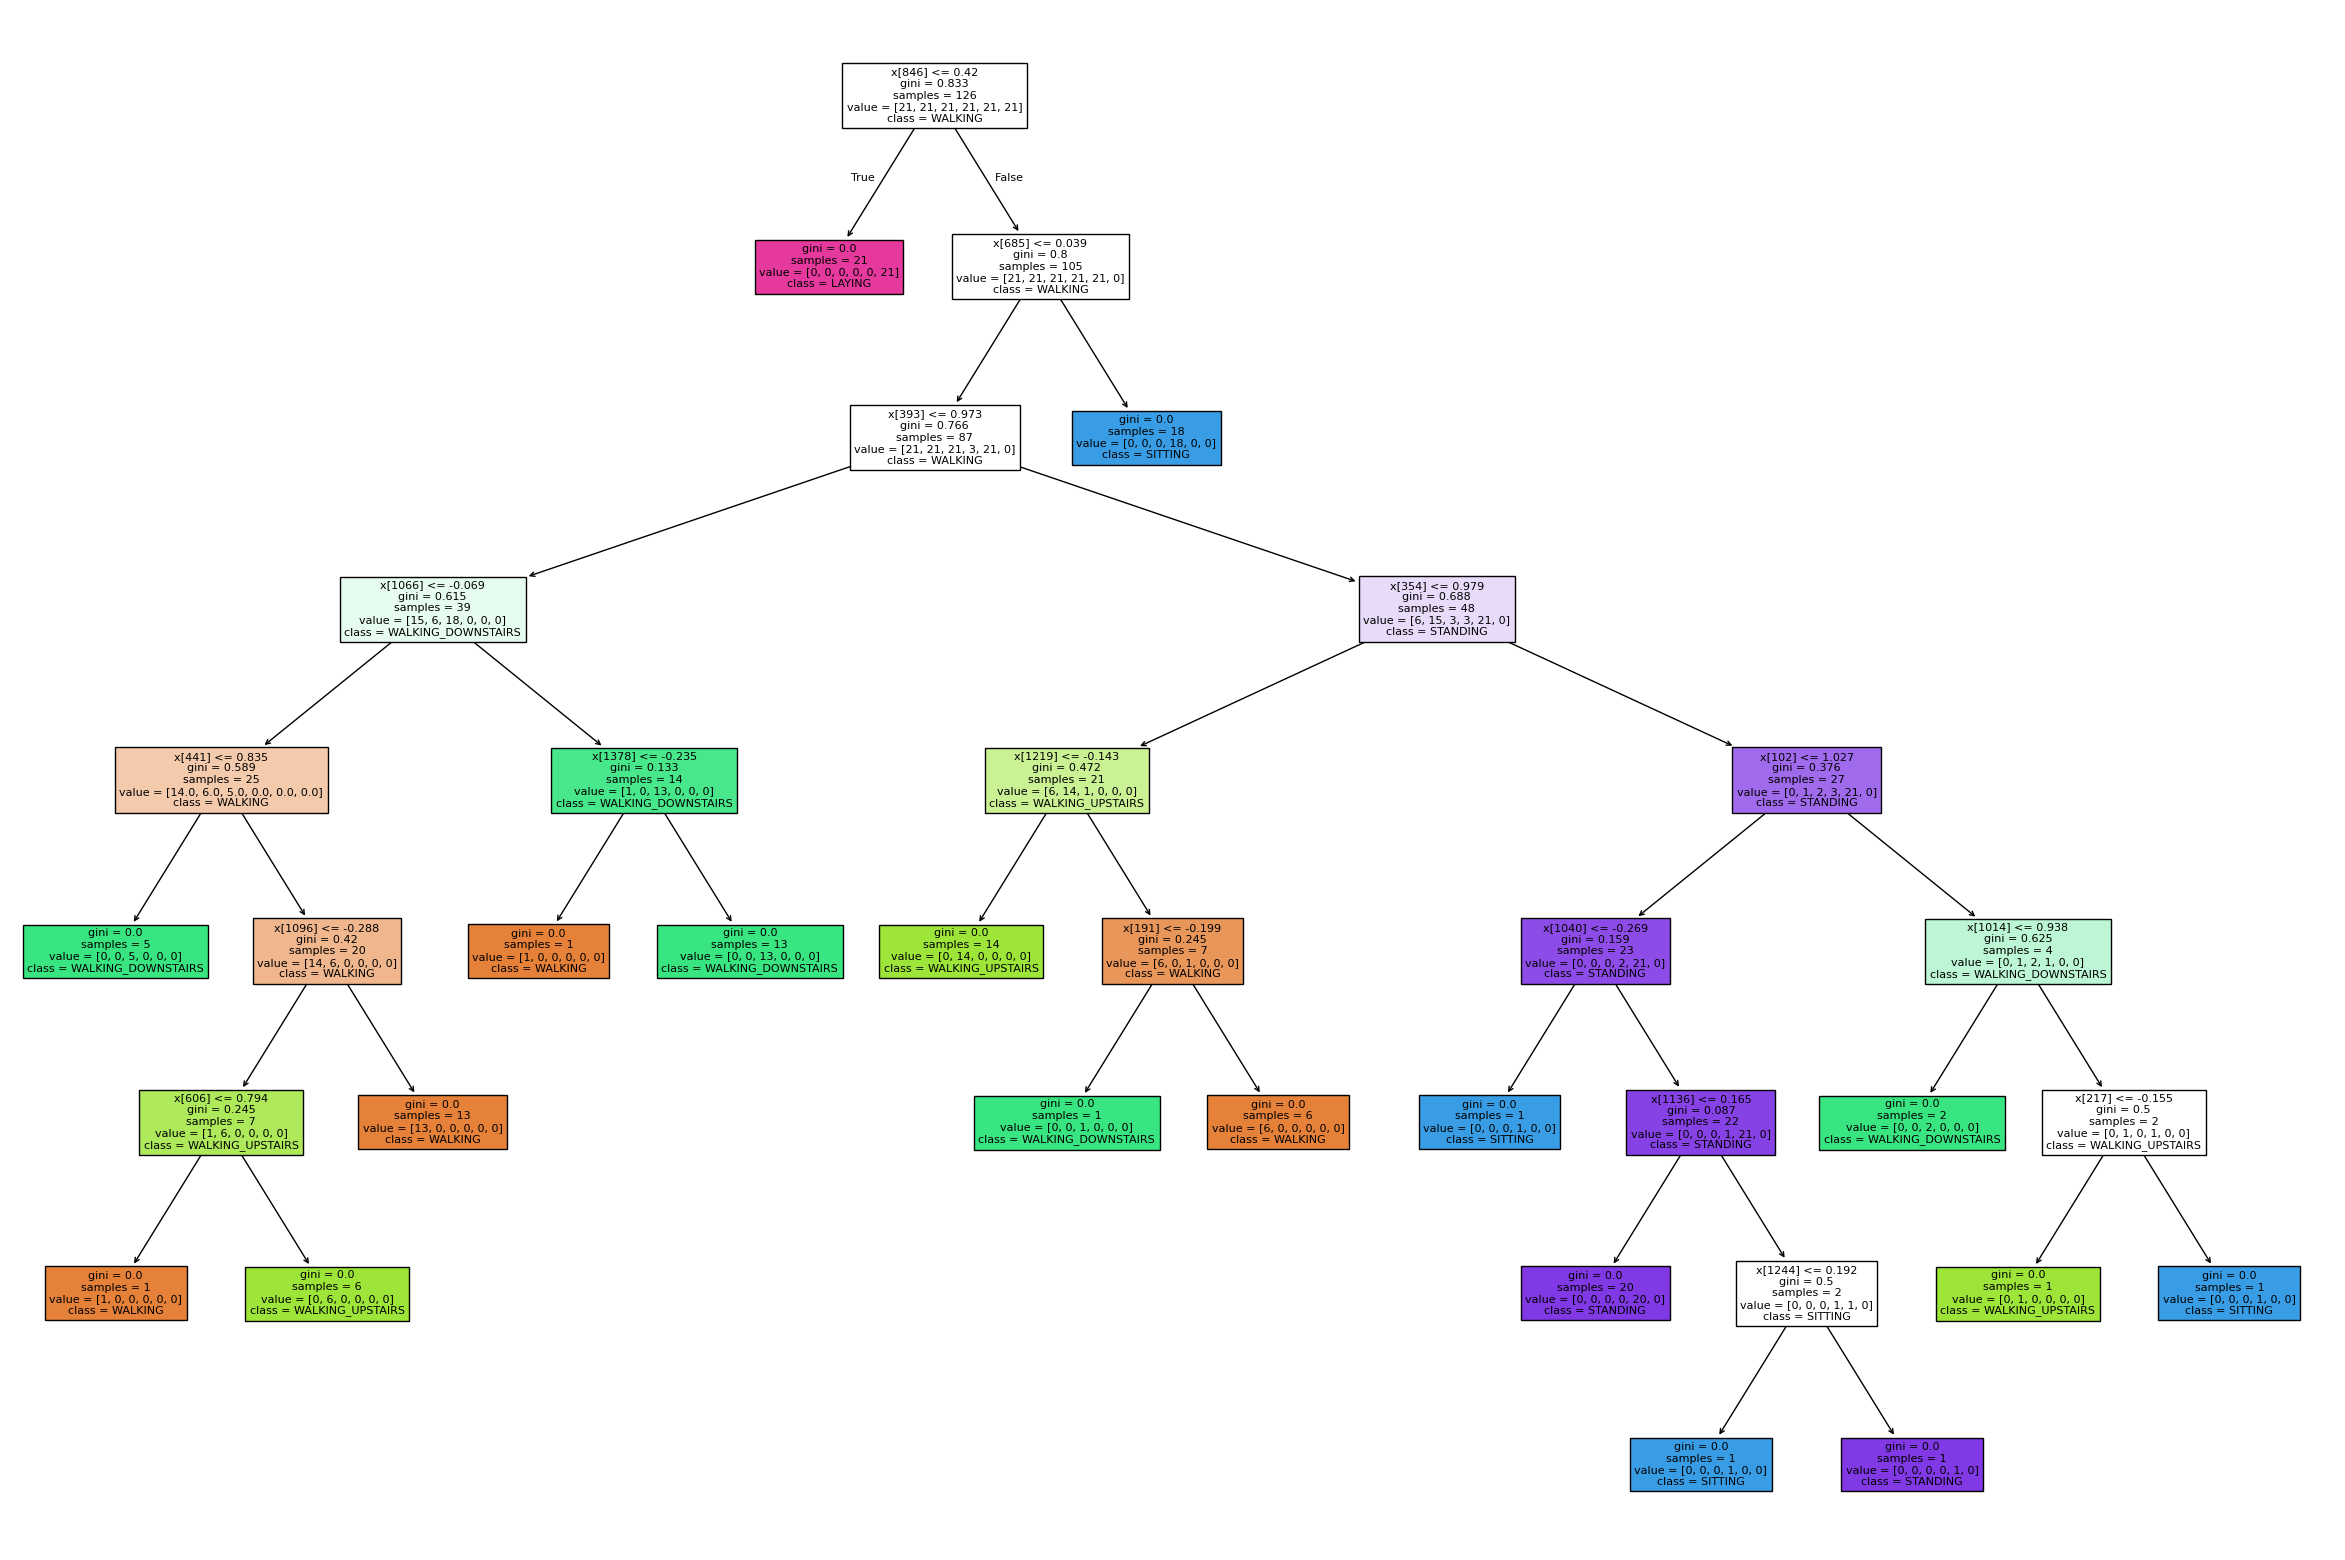

In [229]:
plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True, 
          class_names=activities,
          )    

plt.show()


### Load and Preprocess Train Data

In [ ]:
import os
import numpy as np
import pandas as pd

base_dir = os.path.join("Datasets","TSFEL_3axes_allfeatures\Train")
# Now build path safely

# Desired label mapping
label_map = {
    "WALKING": 1,
    "WALKING_UPSTAIRS": 2,
    "WALKING_DOWNSTAIRS": 3,
    "SITTING": 4,
    "STANDING": 5,
    "LAYING": 6
}

X_list_tsfel, y_list_tsfel = [], []

# Loop through activities in order of label_map
for activity, label in label_map.items():
    act_dir = os.path.join(base_dir, activity)
    files = [f for f in os.listdir(act_dir) if f.lower().endswith(".csv")]
    files.sort()  # ensure consistent order

    # Take first 3 files from each activity
    for fname in files[:]:
        fpath = os.path.join(act_dir, fname)
        df = pd.read_csv(fpath)

        # Keep numeric columns only
        df = df.select_dtypes(include=[np.number])

        # Store data and label
        X_list_tsfel.append(df.values)  # (T, F)
        y_list_tsfel.append(label)

# Convert to arrays
X1 = np.array(X_list_tsfel, dtype=float)   # (18, T, F)
X_train_flat_tsfel = X1.reshape(X1.shape[0], -1)  # (18, T*F)
y_train_tsfel = np.array(y_list_tsfel, dtype=int)

# Print checks
print("X shape       :", X1.shape)
print("X_train_flat shape  :", X_train_flat_tsfel.shape)
print("y_train shape  :", y_train_tsfel.shape)






<>:6: SyntaxWarning: invalid escape sequence '\T'
<>:6: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ginis\AppData\Local\Temp\ipykernel_28224\121082851.py:6: SyntaxWarning: invalid escape sequence '\T'
  base_dir = os.path.join("TSFEL_3axes_allfeatures\Train")


X shape       : (126, 1, 489)
X_train_flat shape  : (126, 489)
y_train shape  : (126,)


### Load and Preprocess Test Data

In [ ]:
import os
import numpy as np
import pandas as pd

# Now build path safely
base_dir = os.path.join("TSFEL_Processed_Trim_allfeatures\TSFEL_Processed_Trim_allfeatures")
    
# Desired label mapping
label_map = {
    "WALKING": 1,
    "WALKING_UPSTAIRS": 2,
    "WALKING_DOWNSTAIRS": 3,
    "SITTING": 4,
    "STANDING": 5,
    "LAYING": 6
}

X_list_tsfel, y_list_tsfel = [], []

# Loop through activities in order of label_map
for activity, label in label_map.items():
    act_dir = os.path.join(base_dir, activity)
    files = [f for f in os.listdir(act_dir) if f.lower().endswith(".csv")]
    files.sort()  # ensure consistent order

  
    for fname in files[:]:
        fpath = os.path.join(act_dir, fname)
        df = pd.read_csv(fpath)

        # Keep numeric columns only
        df = df.select_dtypes(include=[np.number])

        # Store data and label
        X_list_tsfel.append(df.values)  # (T, F)
        y_list_tsfel.append(label)

# Convert to arrays
X1 = np.array(X_list_tsfel, dtype=float)   # (18, T, F)
X_test_flat_tsfel = X1.reshape(X1.shape[0], -1)  # (18, T*F)
y_test_tsfel = np.array(y_list_tsfel, dtype=int)

# Print checks
print("X shape       :", X1.shape)
print("X_test_flat shape  :", X_test_flat_tsfel.shape)
print("y_test shape  :", y_test_tsfel.shape)


row_index = 0


<>:6: SyntaxWarning: invalid escape sequence '\T'
<>:6: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ginis\AppData\Local\Temp\ipykernel_28224\2786071061.py:6: SyntaxWarning: invalid escape sequence '\T'
  base_dir = os.path.join("TSFEL_Processed_Trim_allfeatures\TSFEL_Processed_Trim_allfeatures")


X shape       : (18, 1, 489)
X_test_flat shape  : (18, 489)
y_test shape  : (18,)


### UCI HAR Data
We cant use the decision tree modelled on 561 feature data provided by the author, because we have only measured linear acceleration in x, y, z directions and we don't have access to all the other features provided by the author.

### Training Decision Tree on UCI HAR TSFEL data, testing on custom TSFEL data

In [232]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat_tsfel, y_train_tsfel)
depth = clf.get_depth()
print("Depth of Decision Tree:", depth)
y_pred_tsfel = clf.predict(X_test_flat_tsfel)

print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Depth of Decision Tree: 5
Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



### Classification Report, Confusion Matrix and Decision Tree

In [233]:


# 1. Classification Report (per-class + macro/micro avg)
print("Classification Report:\n")
print(classification_report(y_test_tsfel, y_pred_tsfel, target_names=activities))

# 2. Overall Accuracy
accuracy = accuracy_score(y_test_tsfel, y_pred_tsfel)
print(f"Overall Accuracy: {accuracy:.4f}")

# 3. Macro Precision & Recall
precision_macro = precision_score(y_test_tsfel, y_pred_tsfel, average='macro')
recall_macro = recall_score(y_test_tsfel, y_pred_tsfel, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00         3
  WALKING_UPSTAIRS       0.00      0.00      0.00         3
WALKING_DOWNSTAIRS       0.27      1.00      0.43         3
           SITTING       0.00      0.00      0.00         3
          STANDING       0.00      0.00      0.00         3
            LAYING       0.50      1.00      0.67         3

          accuracy                           0.33        18
         macro avg       0.13      0.33      0.18        18
      weighted avg       0.13      0.33      0.18        18

Overall Accuracy: 0.3333
Macro Precision: 0.1288
Macro Recall:    0.3333


c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

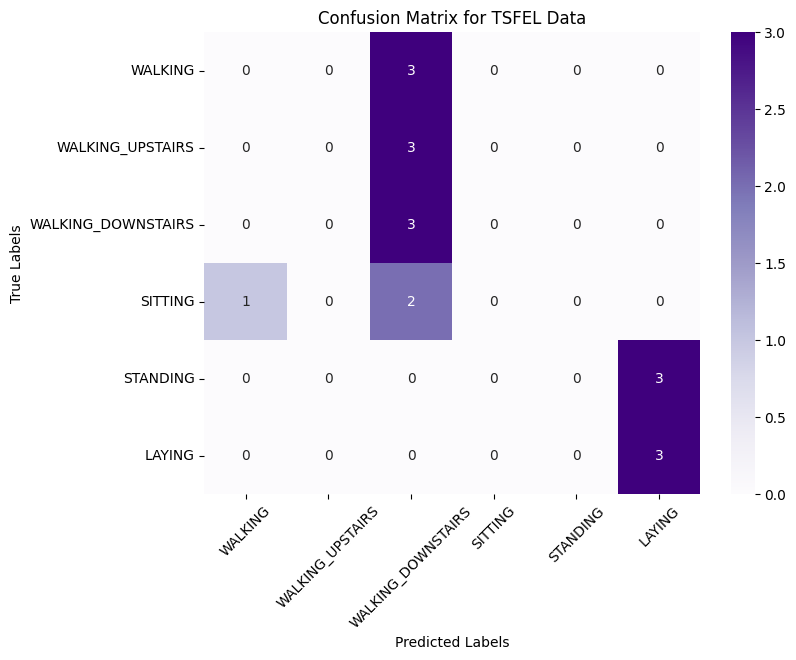

In [234]:

conf_matrix = confusion_matrix(y_test_tsfel, y_pred_tsfel)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', 
            xticklabels=activities, 
            yticklabels=activities)

plt.xticks(rotation=45)  
plt.yticks()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for TSFEL Data')

plt.show()


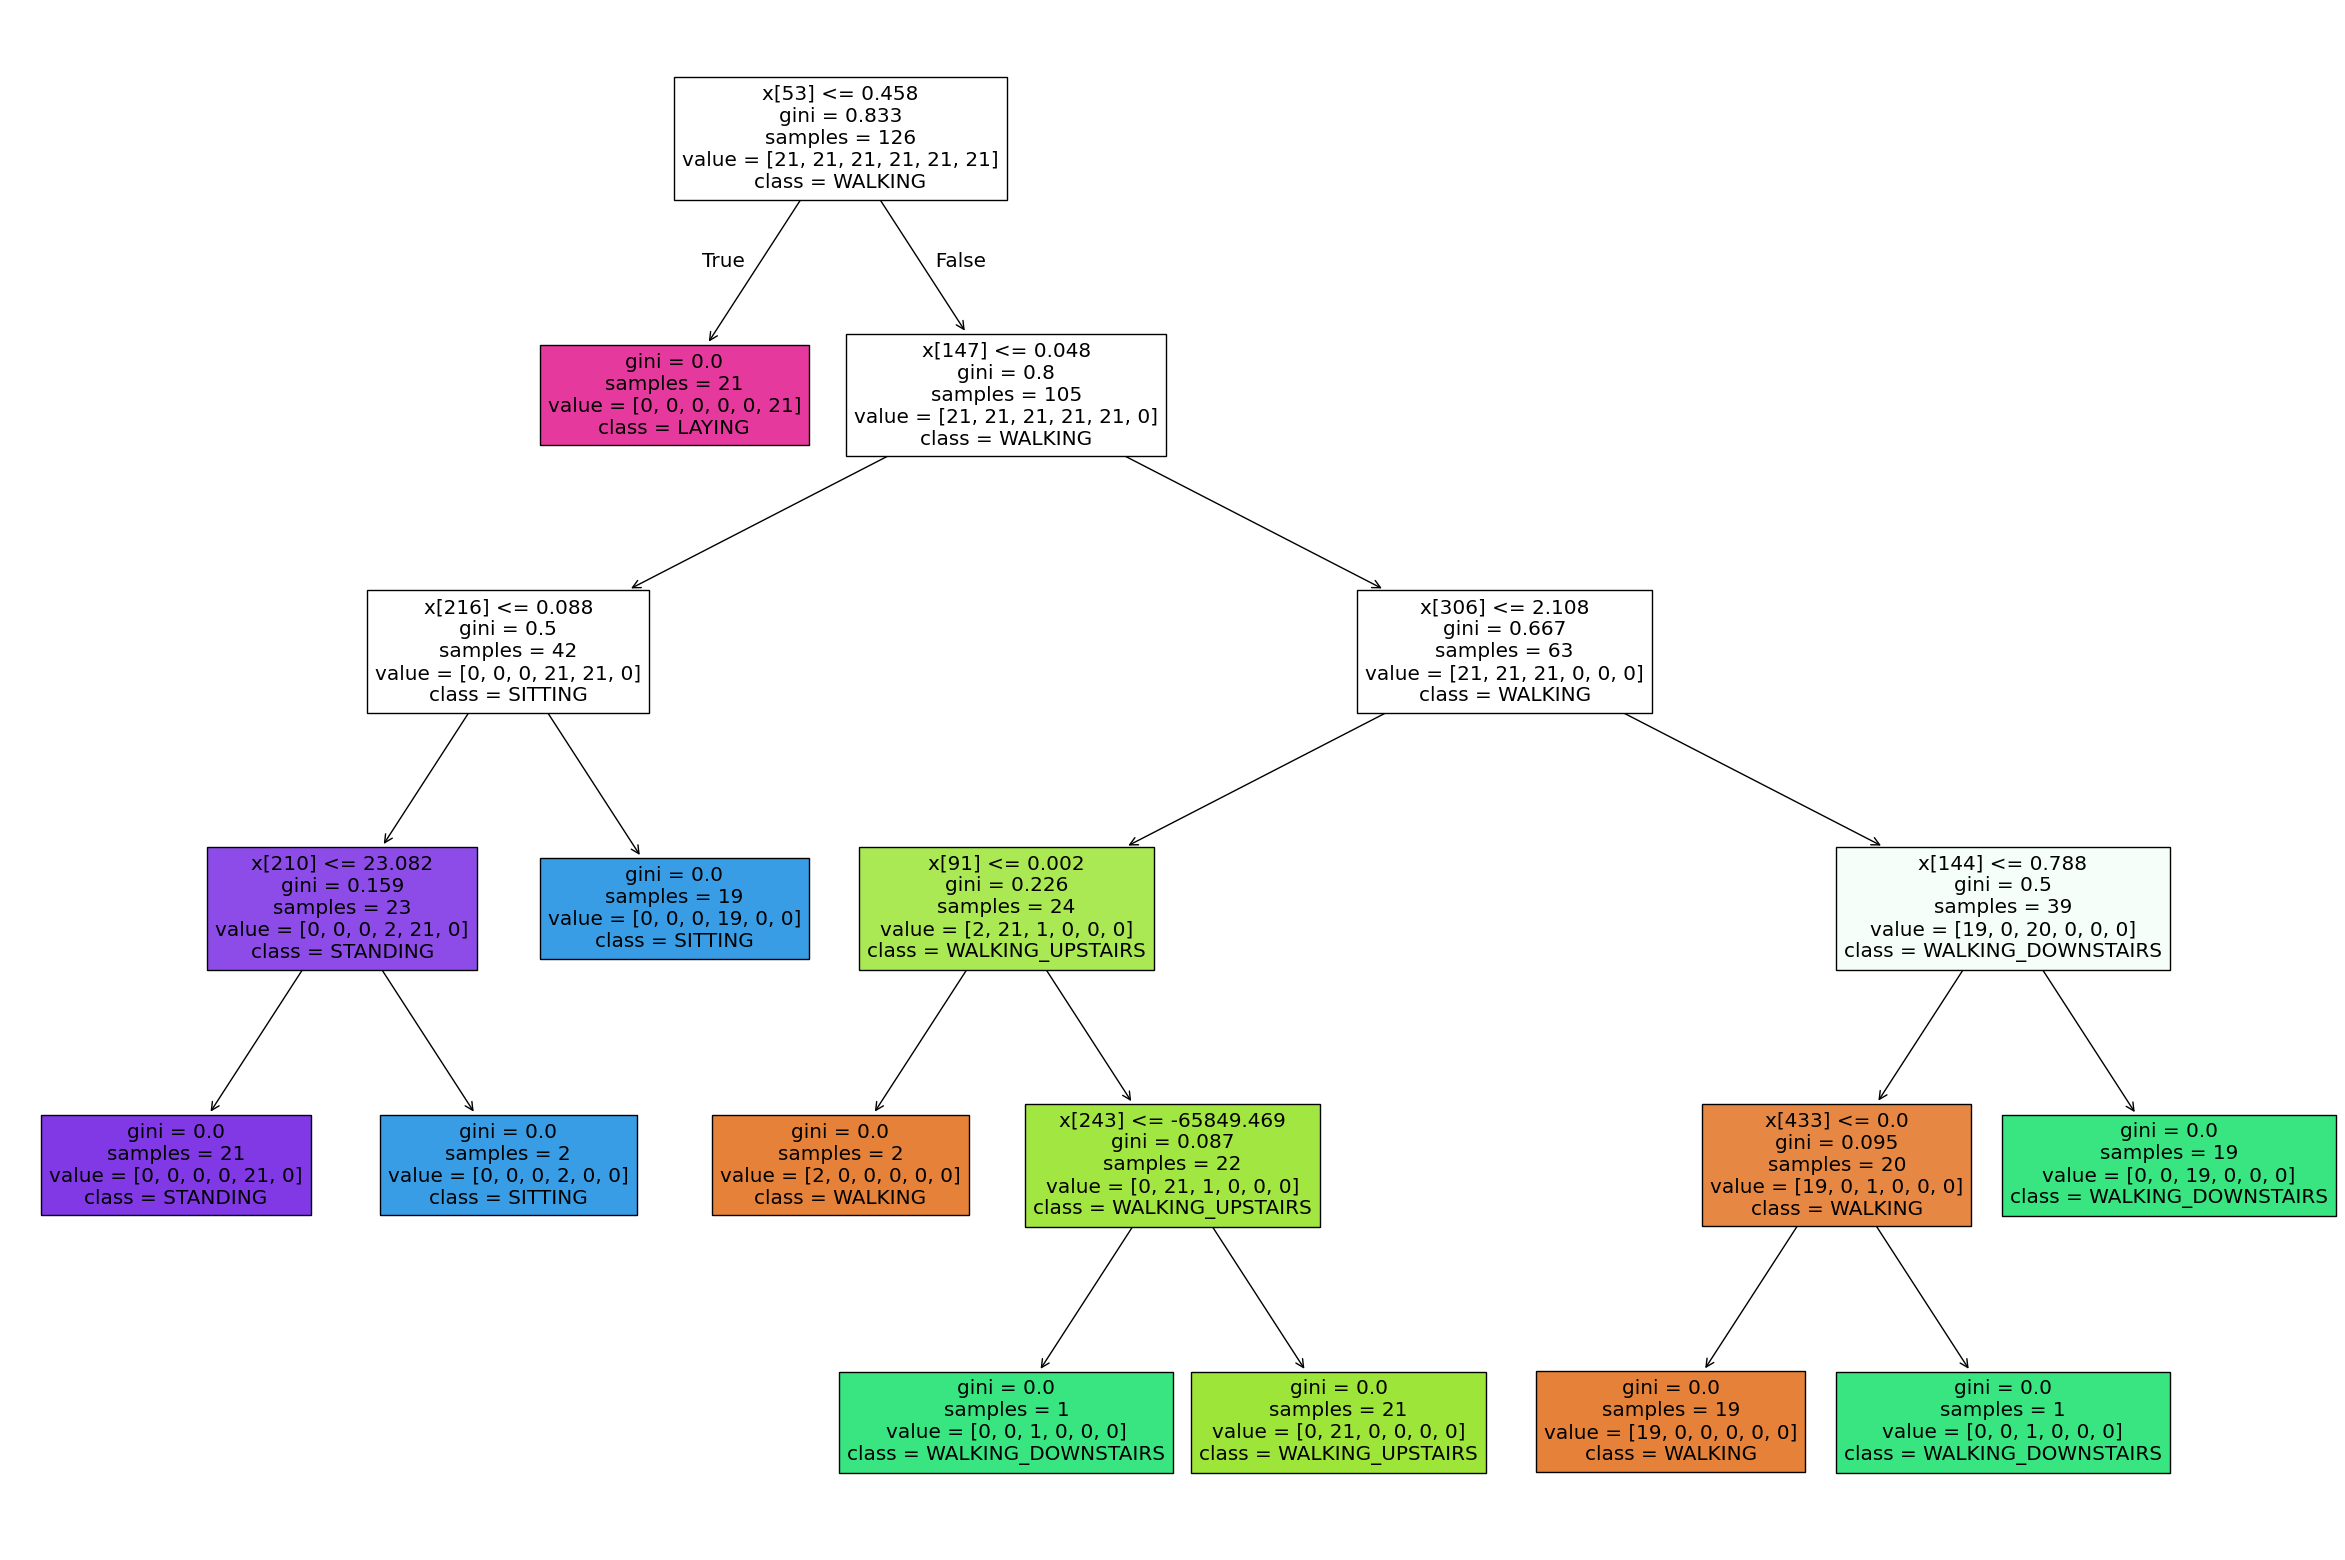

In [235]:
plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True, 
          class_names=activities,
          )    

plt.show()


### Load and Preprocess Train Data

In [ ]:
import os
import numpy as np
import pandas as pd
# Now build path safely
base_dir = os.path.join("Datasets","Train_data\Train_data")


# Desired label mapping
label_map = {
    "WALKING": 1,
    "WALKING_UPSTAIRS": 2,
    "WALKING_DOWNSTAIRS": 3,
    "SITTING": 4,
    "STANDING": 5,
    "LAYING": 6
}

X_list, y_list = [], []

# Loop through activities in order of label_map
for activity, label in label_map.items():
    act_dir = os.path.join(base_dir, activity)
    files = [f for f in os.listdir(act_dir) if f.lower().endswith(".csv")]
    files.sort()  # ensure consistent order

    # Take first 3 files from each activity
    for fname in files[:]:
        fpath = os.path.join(act_dir, fname)
        df = pd.read_csv(fpath)

        # Keep numeric columns only
        df = df.select_dtypes(include=[np.number])

        # Store data and label
        X_list.append(df.values)  # (T, F)
        y_list.append(label)

# Convert to arrays
X = np.array(X_list, dtype=float)   # (18, T, F)
X_train_flat_raw = X.reshape(X.shape[0], -1)  # (18, T*F)
y_train_raw = np.array(y_list, dtype=int)

# Print checks
print("X shape       :", X.shape)
print("X_train_flat shape  :", X_train_flat_raw.shape)
print("y_train shape  :", y_train_raw.shape)



X shape       : (12, 500, 3)
X_train_flat shape  : (12, 1500)
y_train shape  : (12,)


<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ginis\AppData\Local\Temp\ipykernel_28224\540422753.py:5: SyntaxWarning: invalid escape sequence '\T'
  base_dir = os.path.join("Train_data\Train_data")


### Load and Preprocess Test Data

In [ ]:
import os
import numpy as np
import pandas as pd
# Now build path safely
base_dir = os.path.join("Datasets","Test_data\Test_data")
# Desired label mapping
label_map = {
    "WALKING": 1,
    "WALKING_UPSTAIRS": 2,
    "WALKING_DOWNSTAIRS": 3,
    "SITTING": 4,
    "STANDING": 5,
    "LAYING": 6
}

X_list, y_list = [], []

# Loop through activities in order of label_map
for activity, label in label_map.items():
    act_dir = os.path.join(base_dir, activity)
    files = [f for f in os.listdir(act_dir) if f.lower().endswith(".csv")]
    files.sort()  # ensure consistent order

    # Take first 3 files from each activity
    for fname in files[:]:
        fpath = os.path.join(act_dir, fname)
        df = pd.read_csv(fpath)

        # Keep numeric columns only
        df = df.select_dtypes(include=[np.number])

        # Store data and label
        X_list.append(df.values)  # (T, F)
        y_list.append(label)

# Convert to arrays
X = np.array(X_list, dtype=float)   # (18, T, F)
X_test_flat_raw = X.reshape(X.shape[0], -1)  # (18, T*F)
y_test_raw = np.array(y_list, dtype=int)

# Print checks
print("X shape       :", X.shape)
print("X_test_flat shape  :", X_test_flat_raw.shape)
print("y_test shape  :", y_test_raw.shape)



<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ginis\AppData\Local\Temp\ipykernel_28224\2516105372.py:5: SyntaxWarning: invalid escape sequence '\T'
  base_dir = os.path.join("Test_data\Test_data")


X shape       : (6, 500, 3)
X_test_flat shape  : (6, 1500)
y_test shape  : (6,)


### Training Decision Tree on custom raw data of 2 subjects, testing on custom raw data of 1 subject.

In [238]:

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat_raw, y_train_raw)
depth = clf.get_depth()
print("Depth of Decision Tree:", depth)
y_pred_raw = clf.predict(X_test_flat_raw)

print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")


Depth of Decision Tree: 4
Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



### Classification Report, Confusion Matrix and Decision Tree

In [239]:


# 1. Classification Report (per-class + macro/micro avg)
print("Classification Report:\n")
print(classification_report(y_test_raw, y_pred_raw, target_names=activities))

# 2. Overall Accuracy
accuracy = accuracy_score(y_test_raw, y_pred_raw)
print(f"Overall Accuracy: {accuracy:.4f}")

# 3. Macro Precision & Recall
precision_macro = precision_score(y_test_raw, y_pred_raw, average='macro')
recall_macro = recall_score(y_test_raw, y_pred_raw, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00         1
  WALKING_UPSTAIRS       0.00      0.00      0.00         1
WALKING_DOWNSTAIRS       0.00      0.00      0.00         1
           SITTING       0.00      0.00      0.00         1
          STANDING       0.33      1.00      0.50         1
            LAYING       0.00      0.00      0.00         1

          accuracy                           0.17         6
         macro avg       0.06      0.17      0.08         6
      weighted avg       0.06      0.17      0.08         6

Overall Accuracy: 0.1667
Macro Precision: 0.0556
Macro Recall:    0.1667


c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

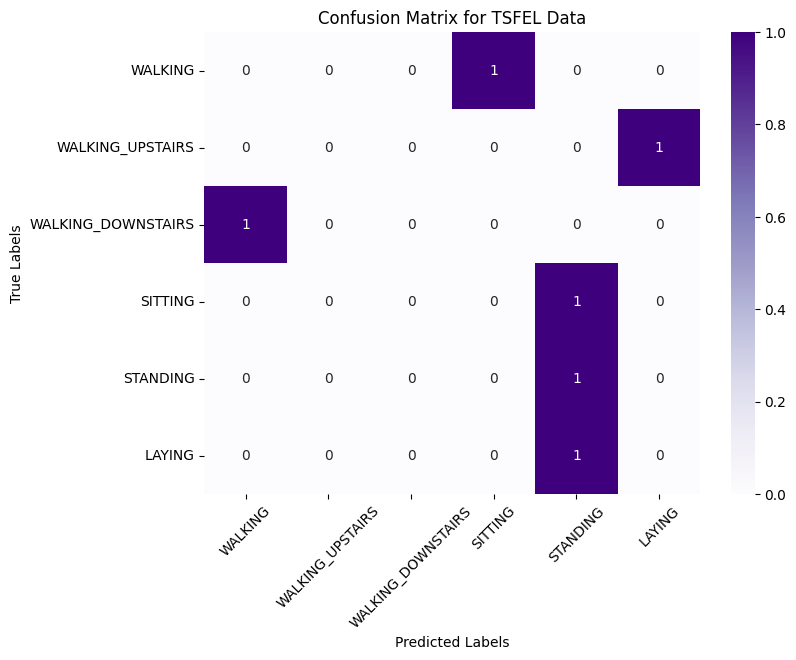

In [240]:


conf_matrix = confusion_matrix(y_test_raw, y_pred_raw)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', 
            xticklabels=activities, 
            yticklabels=activities)

plt.xticks(rotation=45)  
plt.yticks()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for TSFEL Data')

plt.show()

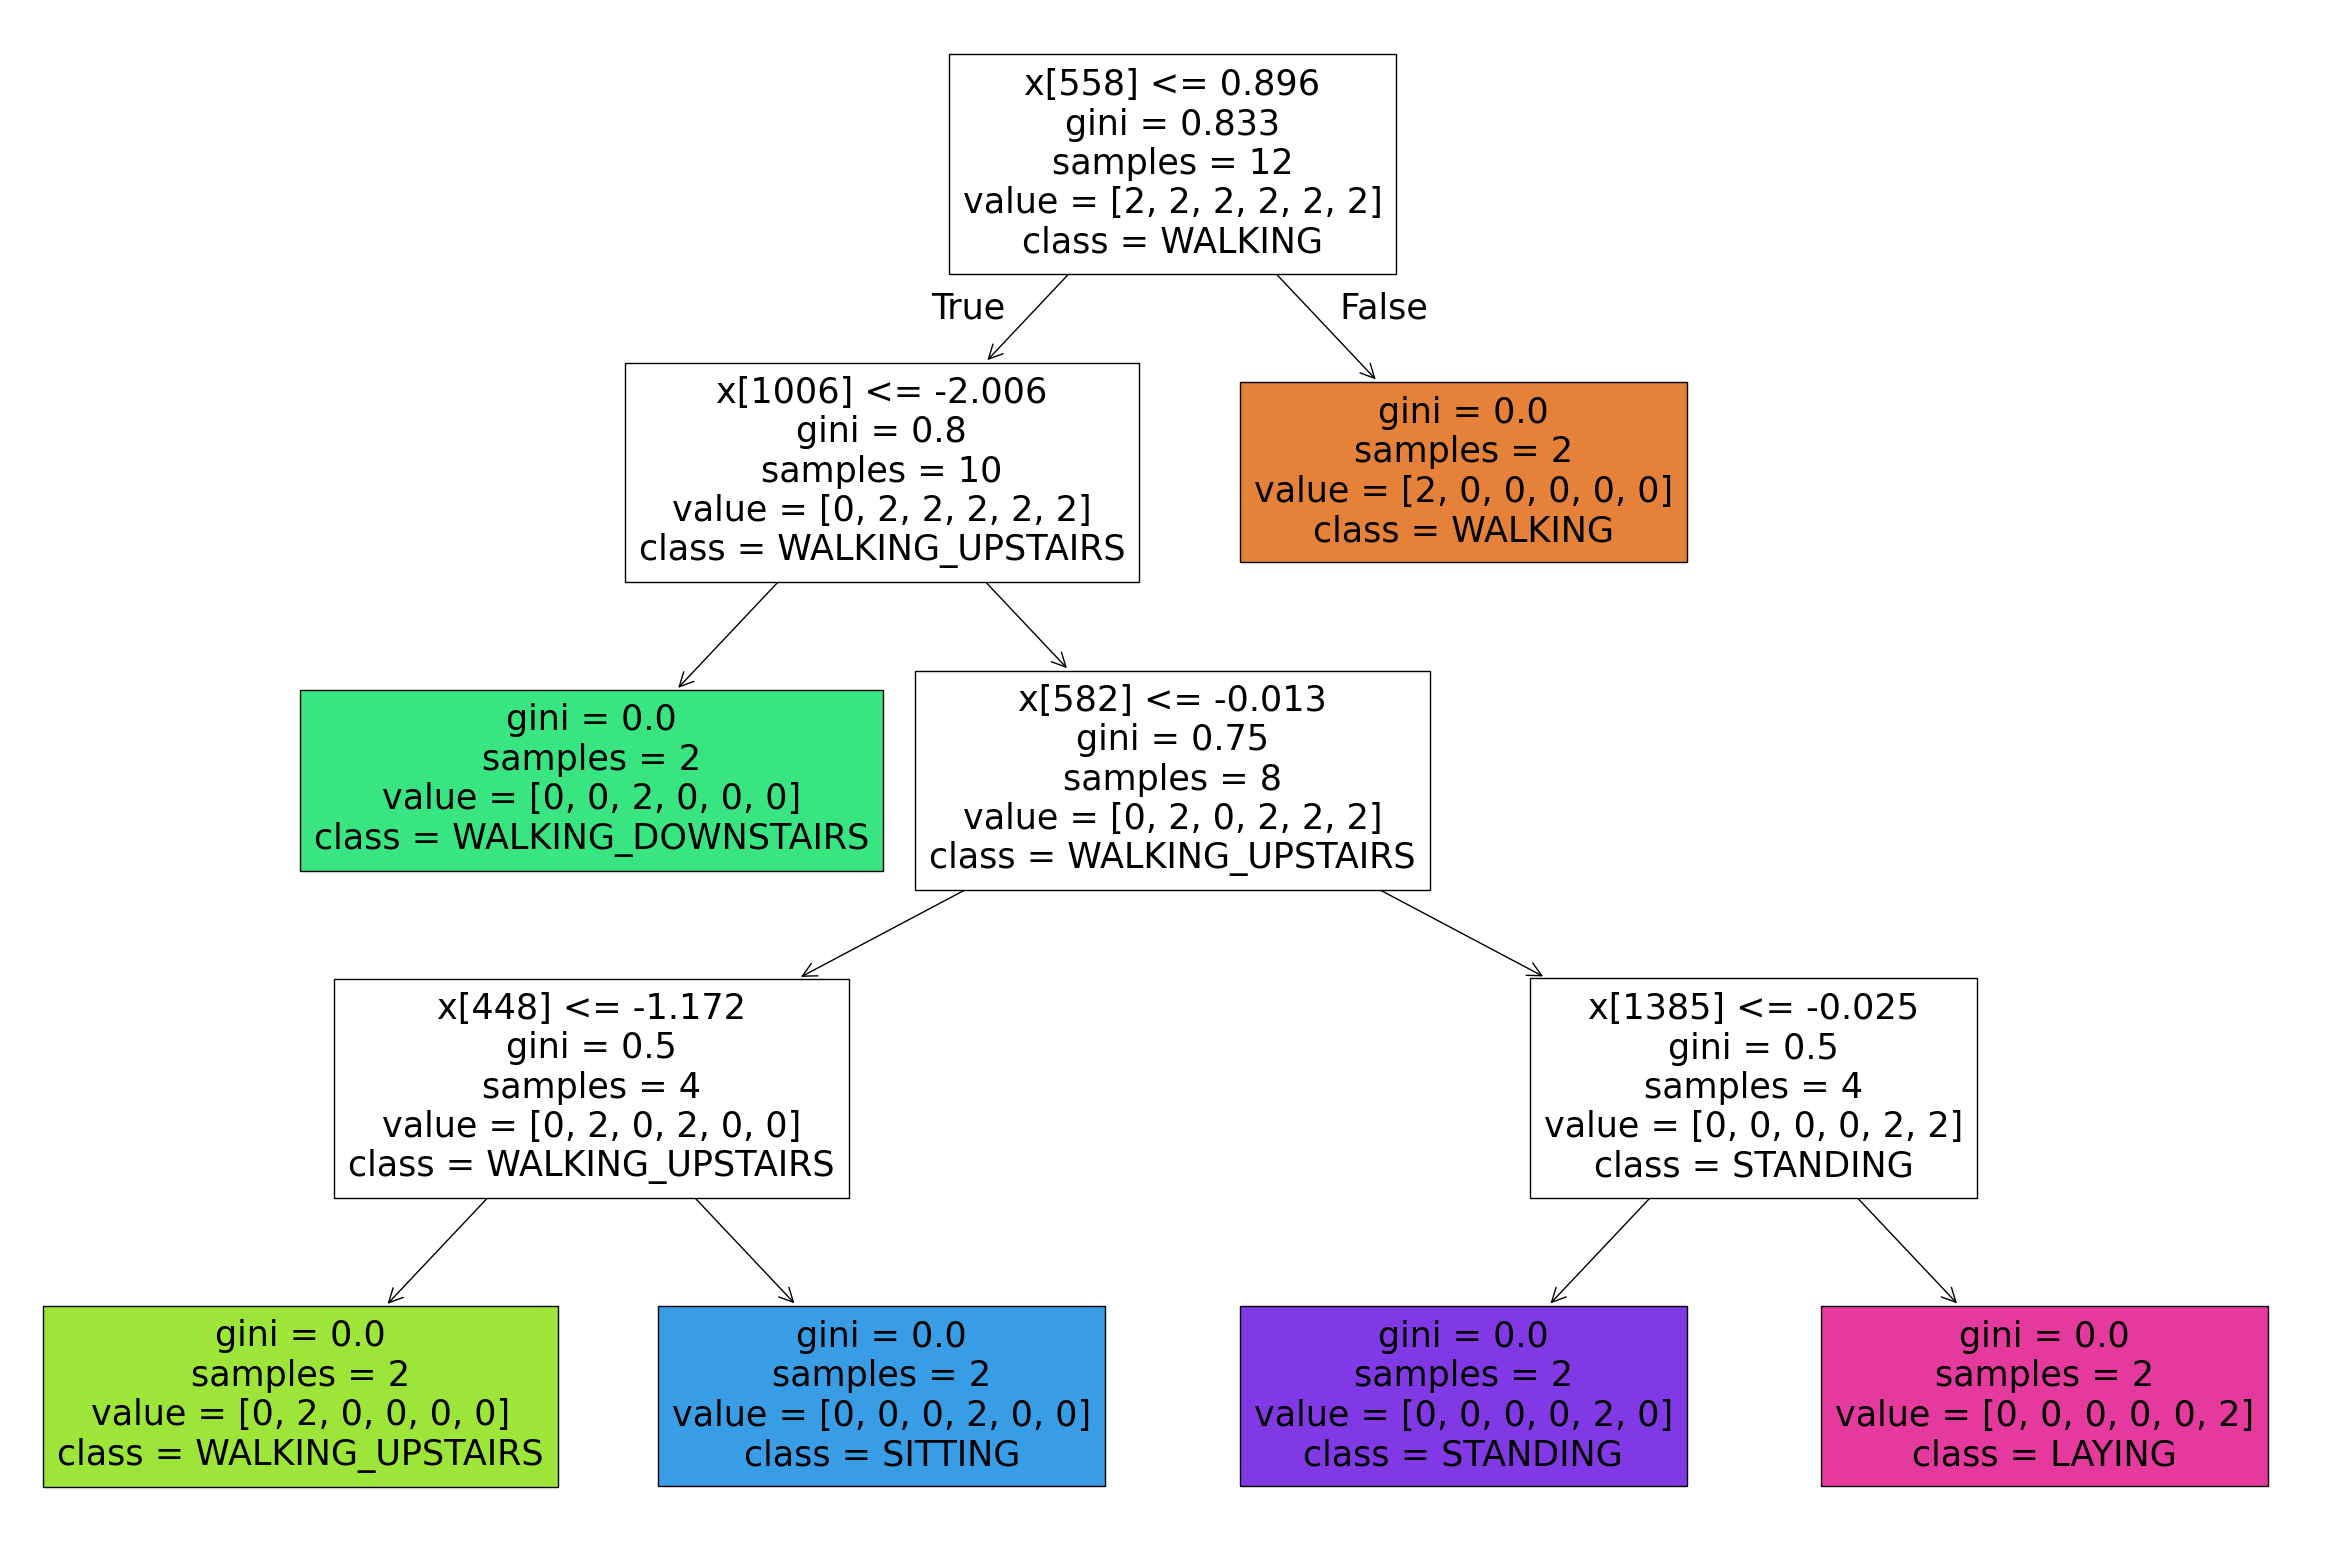

In [241]:

plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True, 
          class_names=activities,
          )    

plt.show()

### Load and Preprocess Train Data

In [ ]:
import os
import numpy as np
import pandas as pd

# Now build path safely

base_dir = os.path.join("Datasets","TSFEL_Train_data_Task3_allfeatures\TSFEL_Train_data_Task3_allfeatures")


# Desired label mapping
label_map = {
    "WALKING": 1,
    "WALKING_UPSTAIRS": 2,
    "WALKING_DOWNSTAIRS": 3,
    "SITTING": 4,
    "STANDING": 5,
    "LAYING": 6
}

X_list, y_list = [], []

# Loop through activities in order of label_map
for activity, label in label_map.items():
    act_dir = os.path.join(base_dir, activity)
    files = [f for f in os.listdir(act_dir) if f.lower().endswith(".csv")]
    files.sort()  # ensure consistent order

    # Take first 3 files from each activity
    for fname in files[:]:
        fpath = os.path.join(act_dir, fname)
        df = pd.read_csv(fpath)

        # Keep numeric columns only
        df = df.select_dtypes(include=[np.number])

        # Store data and label
        X_list.append(df.values)  # (T, F)
        y_list.append(label)

# Convert to arrays
X = np.array(X_list, dtype=float)   # (18, T, F)
X_train_flat2 = X.reshape(X.shape[0], -1)  # (18, T*F)
y_train2 = np.array(y_list, dtype=int)

# Print checks
print("X shape       :", X.shape)
print("X_train_flat shape  :", X_train_flat2.shape)
print("y_train shape  :", y_train2.shape)



<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:7: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ginis\AppData\Local\Temp\ipykernel_28224\944524811.py:7: SyntaxWarning: invalid escape sequence '\T'
  base_dir = os.path.join("TSFEL_Train_data_Task3_allfeatures\TSFEL_Train_data_Task3_allfeatures")


X shape       : (12, 1, 489)
X_train_flat shape  : (12, 489)
y_train shape  : (12,)




### Load and Preprocess Test Data

In [ ]:
import os
import numpy as np
import pandas as pd

# Now build path safely
base_dir = os.path.join("Datasets","TSFEL_Test_data_Task3_allfeatures\TSFEL_Test_data_Task3_allfeatures")

# Desired label mapping
label_map = {
    "WALKING": 1,
    "WALKING_UPSTAIRS": 2,
    "WALKING_DOWNSTAIRS": 3,
    "SITTING": 4,
    "STANDING": 5,
    "LAYING": 6
}

X_list, y_list = [], []

# Loop through activities in order of label_map
for activity, label in label_map.items():
    act_dir = os.path.join(base_dir, activity)
    files = [f for f in os.listdir(act_dir) if f.lower().endswith(".csv")]
    files.sort()  # ensure consistent order

    # Take first 3 files from each activity
    for fname in files[:]:
        fpath = os.path.join(act_dir, fname)
        df = pd.read_csv(fpath)

        # Keep numeric columns only
        df = df.select_dtypes(include=[np.number])

        # Store data and label
        X_list.append(df.values)  # (T, F)
        y_list.append(label)

# Convert to arrays
X = np.array(X_list, dtype=float)   # (18, T, F)
X_test_flat2 = X.reshape(X.shape[0], -1)  # (18, T*F)
y_test2 = np.array(y_list, dtype=int)

# Print checks
print("X shape       :", X.shape)
print("X_test_flat shape  :", X_test_flat2.shape)
print("y_test shape  :", y_test2.shape)



X shape       : (6, 1, 489)
X_test_flat shape  : (6, 489)
y_test shape  : (6,)


<>:6: SyntaxWarning: invalid escape sequence '\T'
<>:6: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ginis\AppData\Local\Temp\ipykernel_28224\1193481639.py:6: SyntaxWarning: invalid escape sequence '\T'
  base_dir = os.path.join("TSFEL_Test_data_Task3_allfeatures\TSFEL_Test_data_Task3_allfeatures")


### Training Decision Tree on custom TSFEL data of 2 subjects, testing on custom TSFEL data of 1 subject.

In [244]:

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat2, y_train2)
depth = clf.get_depth()
print("Depth of Decision Tree:", depth)
y_pred2 = clf.predict(X_test_flat2)

print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")


Depth of Decision Tree: 5
Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



### Classification Report, Confusion Matrix and Decision Tree

In [245]:


# 1. Classification Report (per-class + macro/micro avg)
print("Classification Report:\n")
print(classification_report(y_test2, y_pred2, target_names=activities))

# 2. Overall Accuracy
accuracy = accuracy_score(y_test2, y_pred2)
print(f"Overall Accuracy: {accuracy:.4f}")

# 3. Macro Precision & Recall
precision_macro = precision_score(y_test2, y_pred2, average='macro')
recall_macro = recall_score(y_test2, y_pred2, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       0.33      1.00      0.50         1
  WALKING_UPSTAIRS       0.00      0.00      0.00         1
WALKING_DOWNSTAIRS       0.00      0.00      0.00         1
           SITTING       1.00      1.00      1.00         1
          STANDING       0.00      0.00      0.00         1
            LAYING       0.50      1.00      0.67         1

          accuracy                           0.50         6
         macro avg       0.31      0.50      0.36         6
      weighted avg       0.31      0.50      0.36         6

Overall Accuracy: 0.5000
Macro Precision: 0.3056
Macro Recall:    0.5000


c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

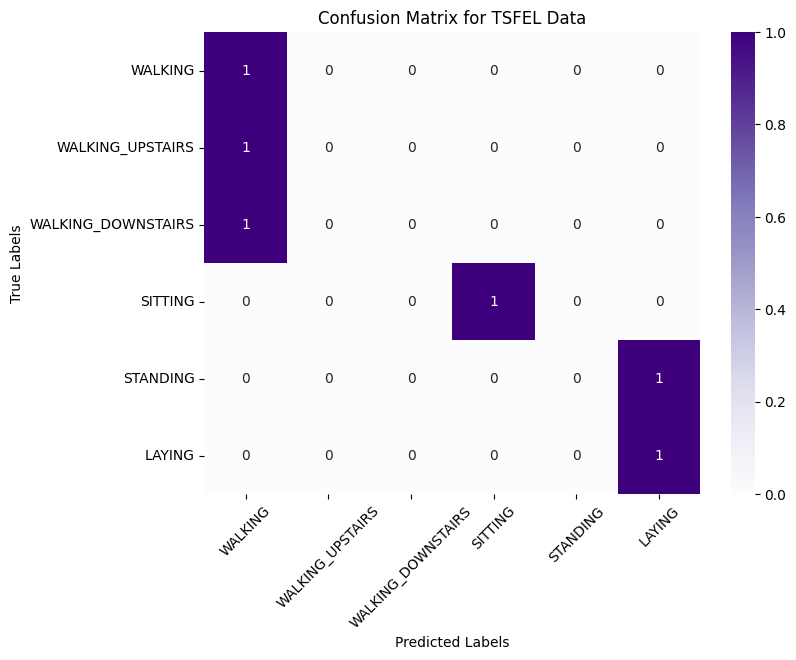

In [246]:

conf_matrix = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', 
            xticklabels=activities, 
            yticklabels=activities)

plt.xticks(rotation=45)  
plt.yticks()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for TSFEL Data')

plt.show()

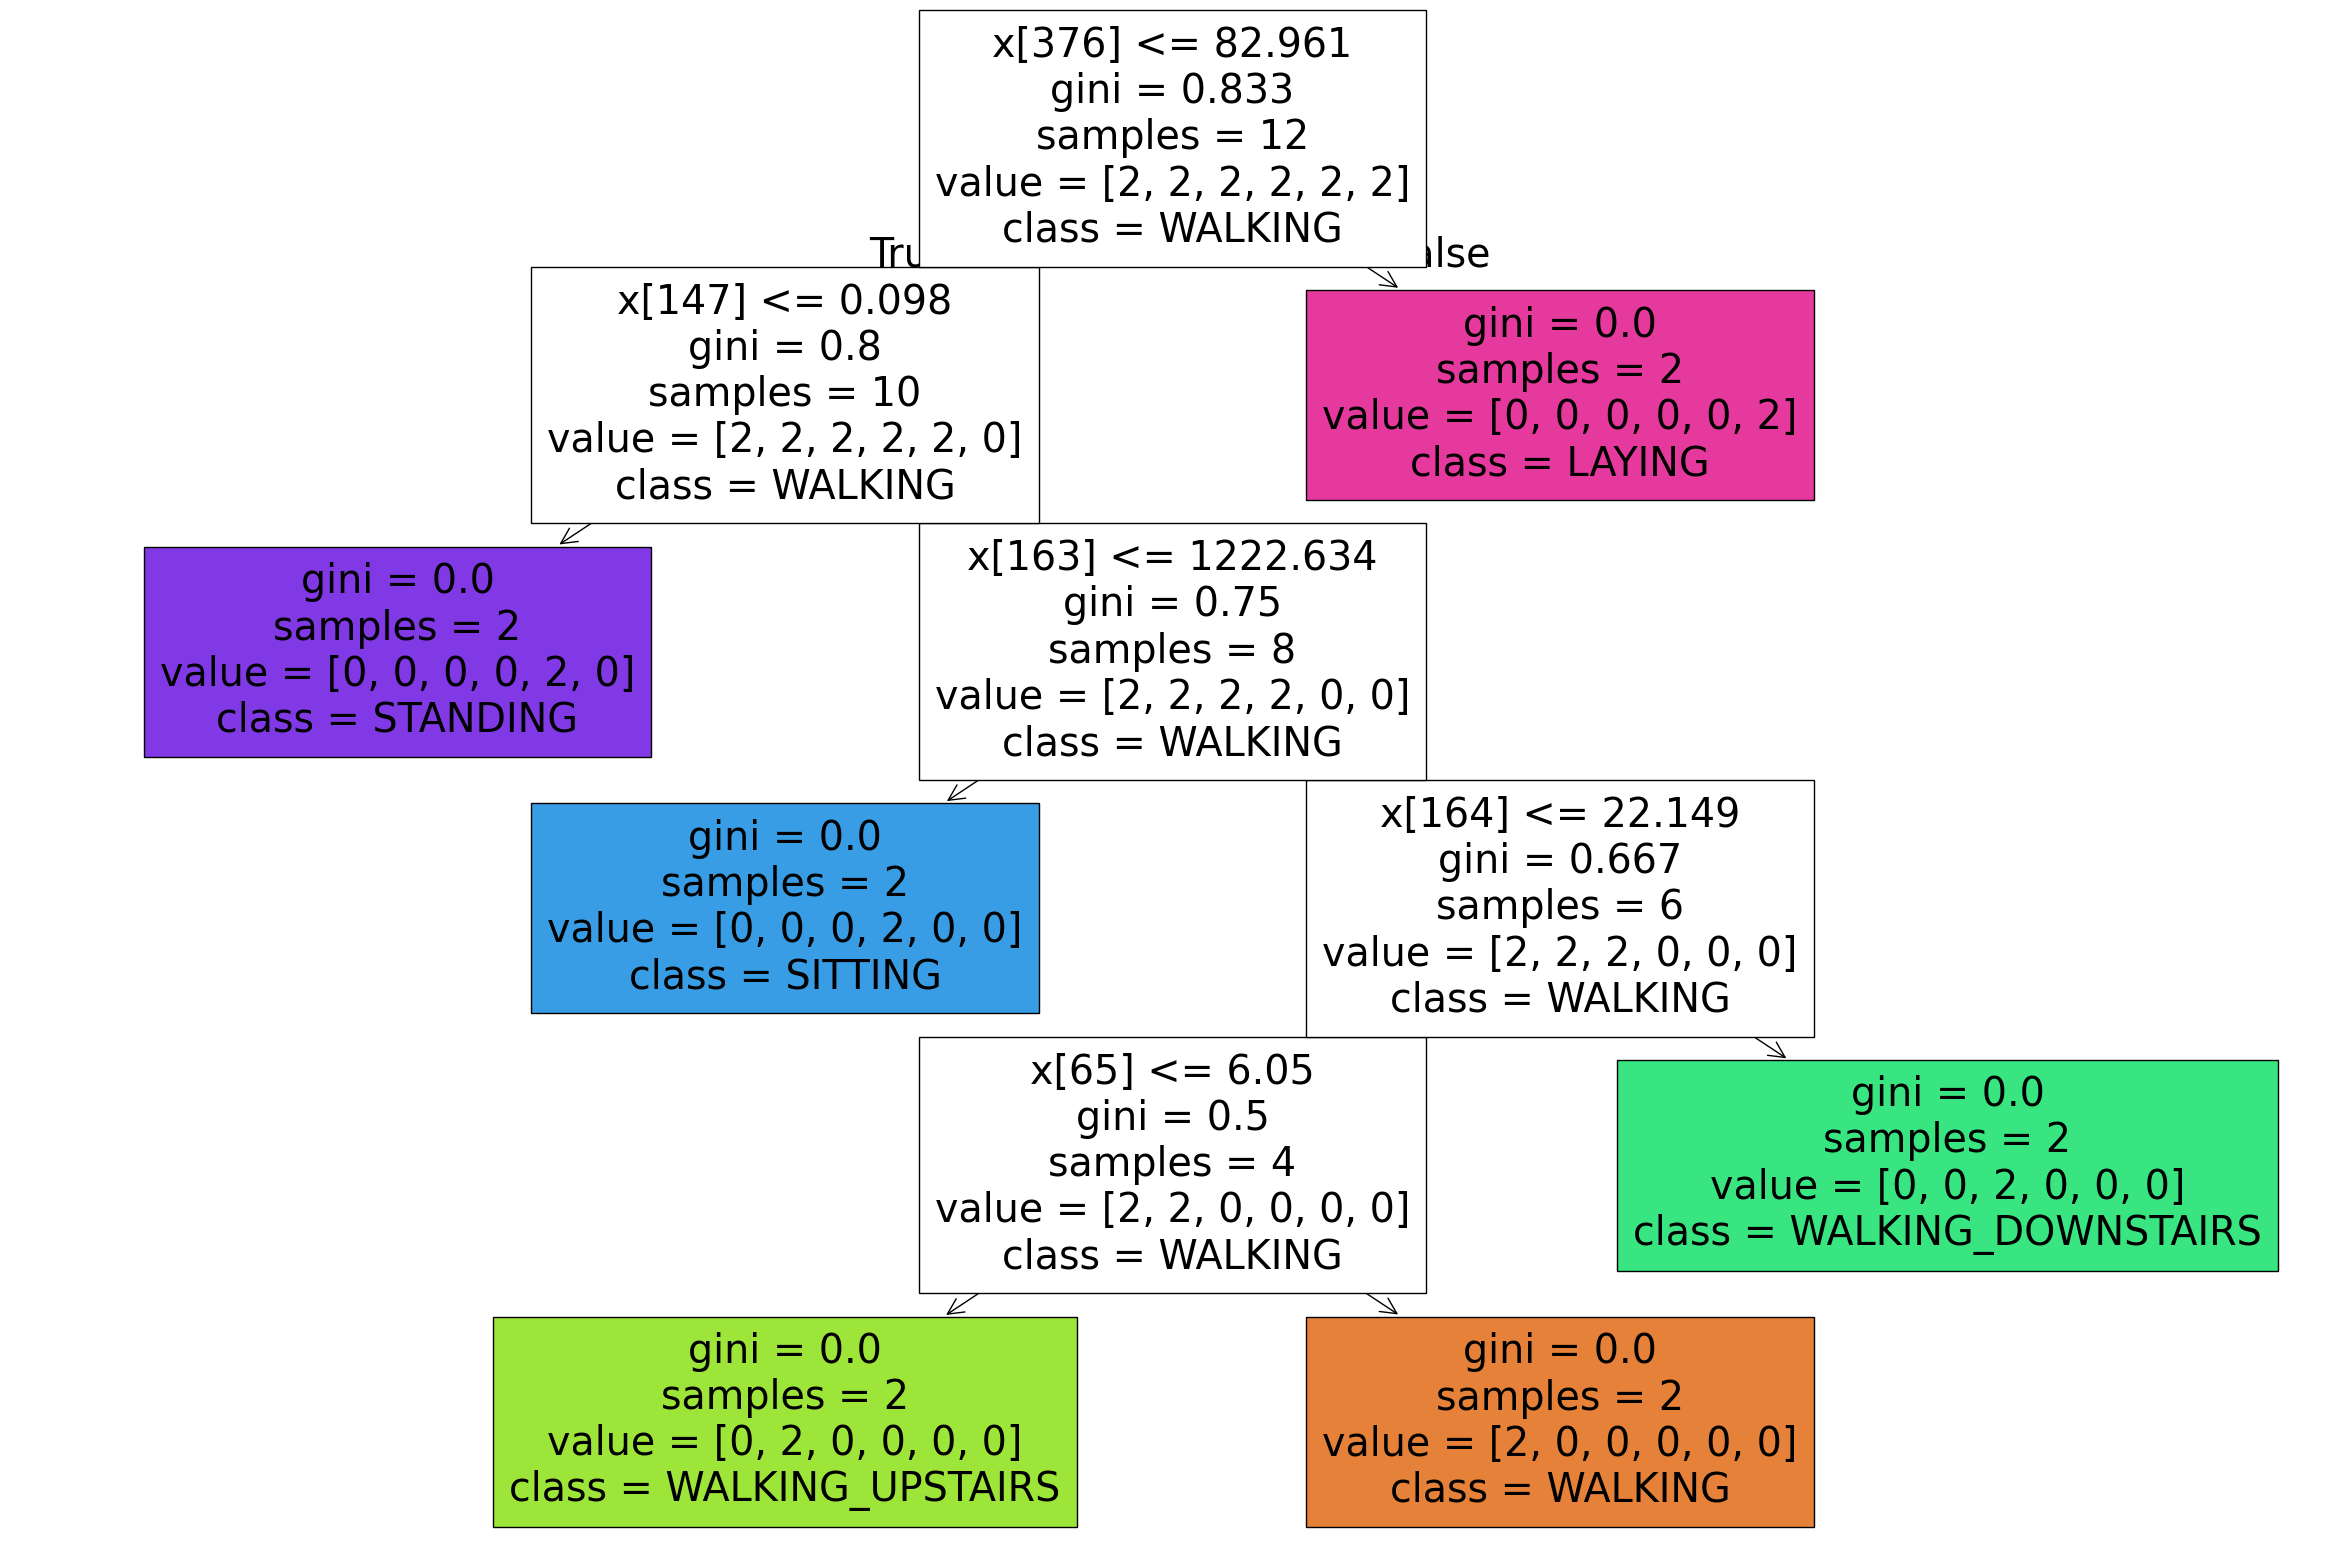

In [247]:

plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True, 
          class_names=activities,
          )    

plt.show()

## Results for Task 4

| Features Type | Training Data | Testing Data | Accuracy | Precision | Recall |
|---------------|---------------|--------------|----------|-----------|--------|
| Raw accelerometer data      | UCI-HAR       | Custom       | 16.67%      | 3.12%       | 16.67%    |
| TSFEL data (all features)    | UCI-HAR       | Custom       | 33.33%      | 12.88%       | 33.33%    |
| Raw accelerometer data | Custom (2 subjects)      | Custom (1 subject)      | 16.67%      | 5.56%       | 16.67%    |
| TSFEL data (all features)      | Custom (2 subjects)      | Custom (1 subject)     | 50.00%      | 30.56%       | 50.00%    |

As we can see, when trained on the custom dataset, the model performs better on the custom dataset when we used TSFEL features with an accuracy of 50% 

When trained on the UCI HAR dataset, the model performs better when we used TSFEL features, with an accuracy of 33%
